In [7]:
import xarray as xr
import pandas as pd
import numpy as np

import hvplot.xarray
import hvplot.pandas

import matplotlib.pyplot as plt
from cycler import cycler

from sstats import signals as sg
from sstats import sigp as sigp
from sstats import tseries as ts
from sstats import get_cmap_colors

import hvplot.xarray
import hvplot.pandas
import holoviews as hv

import pynsitu as pyn
import lib as lib
from lib import KEYS, raw_dir
import os
from glob import glob

import synthetic_traj as st

from synthetic_traj import (
    synthetic_traj,
    noise_irregular_sampling,
    ref_case,
    typical_case,
    negpos_spectra,
)

## Generates

In [8]:
DF = dict()

# TRUE
# t = (50, 1/24/60)
t = (
    np.arange(0, 50 * 24 * 60, 60) / 60 / 24
)  # use it instead of (50, 1/24/60 because otherwise not regularly sampled


N = 10
dst = synthetic_traj(t, N, **ref_case)  # u,v, ax, ay computed
dft = st.dataset2dataframe(dst).rename(columns={"draw": "id"})
DF["True_1min"] = dft

# OBSERVED
position_noise = 20
ntype = "white_noise"
offset_type = "svp_scripps_10"

dso = noise_irregular_sampling(
    dst, t, position_noise, ntype=ntype, offset_type=offset_type
)
dfo = st.dataset2dataframe(dso).rename(columns={"draw": "id"})
dfo = dfo.groupby("id").apply(pyn.geo.compute_dt, time="index")

DF["Observed"] = dfo

# SMOOTHED
dt_smooth = "2h"
dfs = pyn.drifters.smooth_all(
    dfo, "spydell", dt_smooth, parameters=dict(acc_cut=1e-2), geo=False
)
dfl = pyn.drifters.smooth_all(dfo, "lowess", dt_smooth, geo=False)
dfv = pyn.drifters.smooth_all(
    dfo,
    "variational",
    dt_smooth,
    parameters=dict(
        acc_cut=1e-2,
        position_error=position_noise,
        acceleration_amplitude=1.5e-5,
        acceleration_T=5,
        acc_cut_key=("ax", "ay", "Axy"),
    ),
    geo=False,
)

DF["Spydell_" + dt_smooth] = dfs
DF["Lowess_" + dt_smooth] = dfl
DF["Variational_" + dt_smooth] = dfv

# Interpolated True
dsti = dst.interp(time=dfs[dfs.id == 0].index.values)
dsti["dt"] = dsti.time.diff("time") / pd.Timedelta("1s")
dfti = st.dataset2dataframe(dsti).rename(columns={"draw": "id"})

DF["True_" + dt_smooth] = dfti

7914
time
0 days 02:00:00
nb of spike removed 0 over 600
time
0 days 02:00:00
nb of spike removed 0 over 600
time
0 days 02:00:00
nb of spike removed 0 over 600
time
0 days 02:00:00
nb of spike removed 0 over 600
time
0 days 02:00:00
nb of spike removed 0 over 600
time
0 days 02:00:00
nb of spike removed 0 over 600
time
0 days 02:00:00
nb of spike removed 0 over 600
time
0 days 02:00:00
nb of spike removed 0 over 600
time
0 days 02:00:00
nb of spike removed 0 over 600
time
0 days 02:00:00
nb of spike removed 0 over 600
0 single spikes dropped out of 0 potential ones (acceleration threshold)
Chunking dataframe into 2 days chunks
0 single spikes dropped out of 0 potential ones (acceleration threshold)
Chunking dataframe into 2 days chunks
0 single spikes dropped out of 0 potential ones (acceleration threshold)
Chunking dataframe into 2 days chunks
0 single spikes dropped out of 0 potential ones (acceleration threshold)
Chunking dataframe into 2 days chunks
0 single spikes dropped out of 

In [9]:
dfs.dt

time
2000-01-01 00:10:00    7200.0
2000-01-01 02:10:00    7200.0
2000-01-01 04:10:00    7200.0
2000-01-01 06:10:00    7200.0
2000-01-01 08:10:00    7200.0
                        ...  
2000-02-19 14:10:00    7200.0
2000-02-19 16:10:00    7200.0
2000-02-19 18:10:00    7200.0
2000-02-19 20:10:00    7200.0
2000-02-19 22:10:00    7200.0
Name: dt, Length: 6000, dtype: float64

In [10]:
lm = list(DF.keys())
lm

['True_1min',
 'Observed',
 'Spydell_2h',
 'Lowess_2h',
 'Variational_2h',
 'True_2h']

_______
## HVPLOT

In [13]:
def hvplot_DF(DF, d, var=None):
    if not var:
        var = ["x", "y", "u", "v", "ax", "ay"]
    Hv = []
    for v in var:
        init = 0
        for l in DF:
            df = DF[l]
            if init == 0:
                hvplot = df[df.id == d][v].hvplot(label=l)
                init = 1
            hvplot *= df[df.id == d][v].hvplot(label=l)
        Hv.append(hvplot)
    print(len(Hv))
    layout = hv.Layout(Hv[0] + Hv[1] + Hv[2] + Hv[3] + Hv[4] + Hv[5]).cols(2)
    return layout


hvplot_DF(DF, 0)

6


:Layout
   .Overlay.I   :Overlay
      .Curve.True_1min.I    :Curve   [time]   (x)
      .Curve.True_1min.II   :Curve   [time]   (x)
      .Curve.Observed       :Curve   [time]   (x)
      .Curve.Spydell_2h     :Curve   [time]   (x)
      .Curve.Lowess_2h      :Curve   [time]   (x)
      .Curve.Variational_2h :Curve   [time]   (x)
      .Curve.True_2h        :Curve   [time]   (x)
   .Overlay.II  :Overlay
      .Curve.True_1min.I    :Curve   [time]   (y)
      .Curve.True_1min.II   :Curve   [time]   (y)
      .Curve.Observed       :Curve   [time]   (y)
      .Curve.Spydell_2h     :Curve   [time]   (y)
      .Curve.Lowess_2h      :Curve   [time]   (y)
      .Curve.Variational_2h :Curve   [time]   (y)
      .Curve.True_2h        :Curve   [time]   (y)
   .Overlay.III :Overlay
      .Curve.True_1min.I    :Curve   [time]   (u)
      .Curve.True_1min.II   :Curve   [time]   (u)
      .Curve.Observed       :Curve   [time]   (u)
      .Curve.Spydell_2h     :Curve   [time]   (u)
      .Curve.Lowess_2h      :Curve   [time]   (u)
      .Curve.Variational_2h :Curve   [time]   (u)
      .Curve.True_2h        :Curve   [time]   (u)
   .Overlay.IV  :Overlay
      .Curve.True_1min.I    :Curve   [time]   (v)
      .Curve.True_1min.II   :Curve   [time]   (v)
      .Curve.Observed       :Curve   [time]   (v)
      .Curve.Spydell_2h     :Curve   [time]   (v)
      .Curve.Lowess_2h      :Curve   [time]   (v)
      .Curve.Variational_2h :Curve   [time]   (v)
      .Curve.True_2h        :Curve   [time]   (v)
   .Overlay.V   :Overlay
      .Curve.True_1min.I    :Curve   [time]   (ax)
      .Curve.True_1min.II   :Curve   [time]   (ax)
      .Curve.Observed       :Curve   [time]   (ax)
      .Curve.Spydell_2h     :Curve   [time]   (ax)
      .Curve.Lowess_2h      :Curve   [time]   (ax)
      .Curve.Variational_2h :Curve   [time]   (ax)
      .Curve.True_2h        :Curve   [time]   (ax)
   .Overlay.VI  :Overlay
      .Curve.True_1min.I    :Curve   [time]   (ay)
      .Curve.True_1min.II   :Curve   [time]   (ay)
      .Curve.Observed       :Curve   [time]   (ay)
      .Curve.Spydell_2h     :Curve   [time]   (ay)
      .Curve.Lowess_2h      :Curve   [time]   (ay)
      .Curve.Variational_2h :Curve   [time]   (ay)
      .Curve.True_2h        :Curve   [time]   (ay)

_____________
## Compute Mean square values of the differences $\langle (x-x_t)^2 \rangle $ and mean square values of the  relative difference $ \frac{\langle(x-x_t)^2\rangle}{\langle x_t^2 \rangle} $ 

In [14]:
def ms_diff(
    DF,
    true_key="True_" + dt_smooth,
    var=["x", "y", "u", "v", "ax", "ay", "X", "U", "Axy"],
):
    DF = DF.copy()
    dft = DF[true_key]
    dft_ = (dft.set_index("id")[var] ** 2).groupby("id").mean()
    dfms = pd.DataFrame(index=DF.keys(), columns=var)
    dfmsr = pd.DataFrame(index=DF.keys(), columns=var)
    for l in DF:
        df = DF[l]
        if np.all(df.index.values == dft.index.values):
            df_ = df.set_index("id")[var] - dft.set_index("id")[var]
            # dfr_ = (df.set_index('id')[var]-dft.set_index('id')[var])/dft.set_index('id')[var]
            dfms.loc[l] = (df_**2).groupby("id").mean().mean()
            dfmsr.loc[l] = ((df_**2).groupby("id").mean() / dft_).mean()
        else:
            print(l + " has not the same time index")
            continue
    dfms = pd.concat(
        [dfms, dfmsr.rename(columns={v: "ratio_" + v for v in var})], axis=1
    ).dropna()
    return dfms


df_ms_diff = ms_diff(DF)

True_1min has not the same time index
Observed has not the same time index


In [5]:
df_ms_diff

,x,y,u,v,ax,ay,X,U,Axy,ratio_x,ratio_y,ratio_u,ratio_v,ratio_ax,ratio_ay,ratio_X,ratio_U,ratio_Axy
Spydell_2h,2897541.424362,2974636.032348,0.005133,0.005164,0.0,0.0,3107926.557056,0.005646,0.0,0.000056,0.000041,0.039377,0.036478,0.632123,0.586753,0.000012,0.019999,0.53326
Lowess_2h,23287.952693,15538.472446,0.000412,0.000275,0.0,0.0,38247.497048,0.000593,0.0,0.0,0.0,0.002609,0.001874,0.54615,0.423146,0.0,0.001963,0.296287
Variational_2h,86924.550397,94013.334003,0.003603,0.003974,0.0,0.0,116408.845851,0.006447,0.0,0.000001,0.000001,0.026487,0.02633,1.334113,1.64027,0.0,0.022387,0.872428
True_2h,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


_____________
## Compute the difference of mean squares values $\langle x^2 \rangle - \langle x_t^2 \rangle $ and mean square values of the  relative difference $\frac{\langle x^2 \rangle - \langle x_t^2 \rangle}{\langle x_t^2 \rangle}$

No need of same index, but the time sampling should have a large impact on it

In [15]:
def diff_ms(
    DF,
    true_key="True_" + dt_smooth,
    var=["x", "y", "u", "v", "ax", "ay", "X", "U", "Axy"],
):
    DF = DF.copy()
    dft = DF[true_key]
    dfms = pd.DataFrame(index=DF.keys(), columns=var)
    dfmsr = pd.DataFrame(index=DF.keys(), columns=var)
    dft_ = (dft.set_index("id")[var] ** 2).groupby("id").mean()  # mean sur une traj
    for l in DF:
        df = DF[l]
        dfms.loc[l] = (
            (df.set_index("id")[var] ** 2).groupby("id").mean() - dft_
        ).mean()  # mean sur une traj puis sur ttes
        dfmsr.loc[l] = (
            ((dft.set_index("id")[var] ** 2).groupby("id").mean() - dft_) / dft_
        ).mean()
    dfms = pd.concat(
        [dfms, dfmsr.rename(columns={v: "ratio_" + v for v in var})], axis=1
    ).dropna()
    return dfms


diff_ms(DF)

,x,y,u,v,ax,ay,X,U,Axy,ratio_x,ratio_y,ratio_u,ratio_v,ratio_ax,ratio_ay,ratio_X,ratio_U,ratio_Axy
True_1min,139018430.597022,227731619.627239,0.000691,0.000414,0.0,0.0,366557969.447147,0.000616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Observed,-631047976.899614,-944792336.682927,0.000503,-0.000027,0.0,0.0,-1576032394.359641,-0.000011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Spydell_2h,-32743026.183101,7480816.194953,-0.014705,-0.015104,-0.0,-0.0,-25454290.76523,-0.030297,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lowess_2h,659985.695078,966037.699466,0.000116,-0.000252,-0.0,-0.0,1433942.617485,-0.000625,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Variational_2h,66770245.556977,109358549.375891,-0.000237,0.000463,0.0,0.0,175936714.155783,-0.000262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
True_2h,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


_____________
## Compute the ratio of mean squares values $\langle x^2 \rangle/\langle x_t^2 \rangle $ 
No need of same index, but the time sampling should have a large impact on it

In [6]:
def ratio_ms(
    DF,
    true_key="True_" + dt_smooth,
    var=["x", "y", "u", "v", "ax", "ay", "X", "U", "Axy"],
):
    DF = DF.copy()
    dft = DF[true_key]
    dfms = pd.DataFrame(index=DF.keys(), columns=var)
    dft_ = (dft.set_index("id")[var] ** 2).groupby("id").mean()  # mean sur une traj
    for l in DF:
        df = DF[l]
        dfms.loc[l] = (
            (df.set_index("id")[var] ** 2).groupby("id").mean() / dft_
        ).mean()  # mean sur une traj puis sur ttes
    return dfms.dropna()


ratio_ms(DF)

,x,y,u,v,ax,ay,X,U,Axy
True_1min,1.000745,1.00095,1.004814,1.002945,1.21629,1.202593,1.000728,1.002072,1.082924
Observed,1.001176,1.003344,1.004466,1.001349,9.667557,10.73367,1.002643,1.000874,8.609731
Spydell_2h,1.001094,1.001345,0.88597,0.893408,0.252659,0.268847,1.000206,0.892445,0.228165
Lowess_2h,1.000004,1.000005,1.000086,0.998126,0.82601,0.870859,1.000003,0.997582,0.735447
Variational_2h,1.000327,1.000391,1.005533,1.009586,1.956861,2.542184,1.000326,1.006837,1.969347
True_2h,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


_____________
## Compute spectra


In [17]:
def spectrum_df(df, nperseg=24 * 5):
    if "gap_mask" in df and len(df[df.gap_mask == 1]) != 0:
        print("WARNING : INTERPOLATED HOLES")
    ds = df.reset_index().set_index(["time", "id"]).to_xarray()
    vc = [("x", "y"), ("u", "v"), ("ax", "ay")]
    E = []
    for tup in vc:
        ds_ = ds.ts.spectrum(unit="1D", nperseg=nperseg, complex=tup)
        E.append(ds_)
    return xr.merge(E)


def test_regular_dt(df):
    if df.index.name == "time":
        return np.all(
            np.round(df.dt.dropna().values)
            == np.round((df.index[3] - df.index[2]) / pd.Timedelta("1s"))
        )
    else:
        return np.all(
            np.round(df.dt.dropna().values)
            == np.round((df.time[3] - df.time[2]) / pd.Timedelta("1s"))
        )


def spectrum_DF(DF, nperseg=24 * 10):
    DSE = dict()
    for l in DF:
        df = DF[l]
        test = test_regular_dt(df)
        if test_regular_dt(df):
            DSE[l] = spectrum_df(df, nperseg)
            print(l)
        else:
            continue
    return DSE


DSE = spectrum_DF(DF)

True_1min
Spydell_2h
Lowess_2h
Variational_2h
True_2h


In [171]:
DSE["True_2h"]

<xarray.Dataset>
Dimensions:    (id: 10, frequency: 240)
Coordinates:
  * id         (id) int64 0 1 2 3 4 5 6 7 8 9
  * frequency  (frequency) float64 -6.0 -5.95 -5.9 -5.85 ... 5.8 5.85 5.9 5.95
Data variables:
    x_y        (id, frequency) float64 76.55 118.9 116.6 ... 46.9 58.3 146.9
    u_v        (id, frequency) float64 2.111e-05 2.909e-05 ... 6.111e-06
    ax_ay      (id, frequency) float64 2.763e-12 4.217e-12 ... 5.362e-12
    au_av      (id, frequency) float64 2.763e-12 4.217e-12 ... 5.362e-12

In [18]:
DSE["True_1min"]

<xarray.Dataset>
Dimensions:    (id: 10, frequency: 240)
Coordinates:
  * id         (id) int64 0 1 2 3 4 5 6 7 8 9
  * frequency  (frequency) float64 -12.0 -11.9 -11.8 -11.7 ... 11.7 11.8 11.9
Data variables:
    x_y        (id, frequency) float64 3.162 2.888 4.575 ... 2.973 2.927 2.751
    u_v        (id, frequency) float64 1.122e-05 4.754e-06 ... 4.362e-06
    ax_ay      (id, frequency) float64 5.291e-12 2.427e-12 ... 1.769e-12

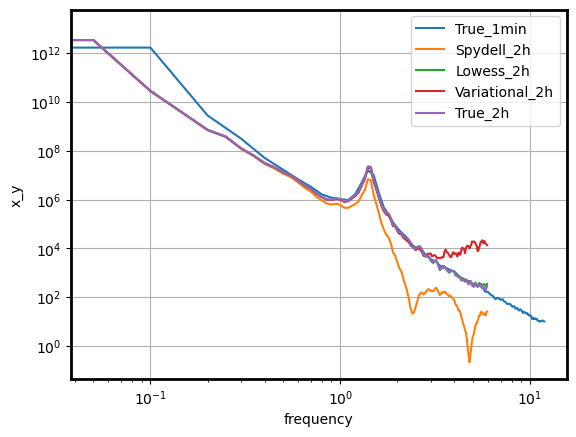

In [172]:
for l in DSE:
    sum(negpos_spectra(DSE[l])).x_y.mean("id").plot(label=l)
plt.grid()
plt.xscale("log")
plt.yscale("log")
plt.legend()

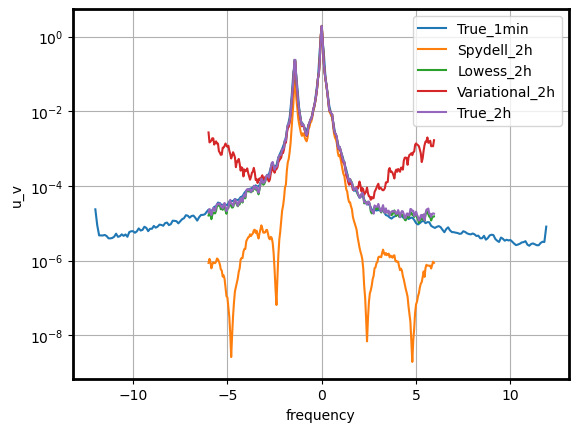

In [173]:
for l in DSE:
    DSE[l].u_v.mean("id").plot(label=l)
# plt.xscale('log')
plt.yscale("log")
plt.grid()
plt.legend()

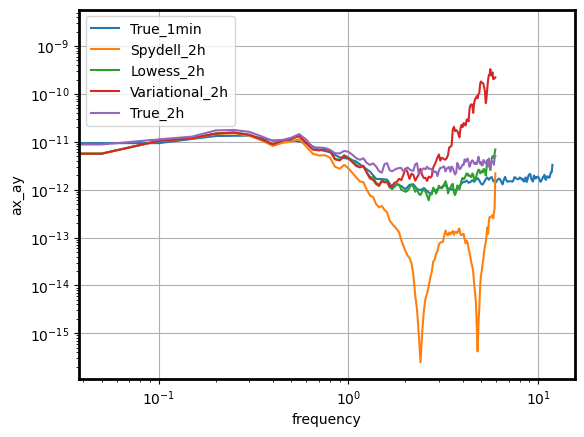

In [174]:
for l in DSE:
    DSE[l].ax_ay.mean("id").plot(label=l)
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.legend()


## Compute spectra of the difference


In [182]:
def build_DF_diff(
    DF,
    true_key="True_" + dt_smooth,
    var=["x", "y", "u", "v", "ax", "ay", "au", "av", "X", "U", "Axy", "Auv"],
):
    dft = DF[true_key]
    DF_diff = dict()
    for l in DF:
        if l == true_key:
            continue
        df = DF[l]
        if np.all(df.index.values == dft.index.values):
            df_ = df[var] - dft[var]
            df_["dt"] = df["dt"]
            df_["id"] = df["id"]
            DF_diff[l] = df_
        else:
            print(l + " has not the same time index")
            continue
    return DF_diff


DF_diff = build_DF_diff(DF)
DSE_diff = spectrum_DF(DF_diff)

True_1min has not the same time index
Observed has not the same time index
Spydell_2h
Lowess_2h
Variational_2h


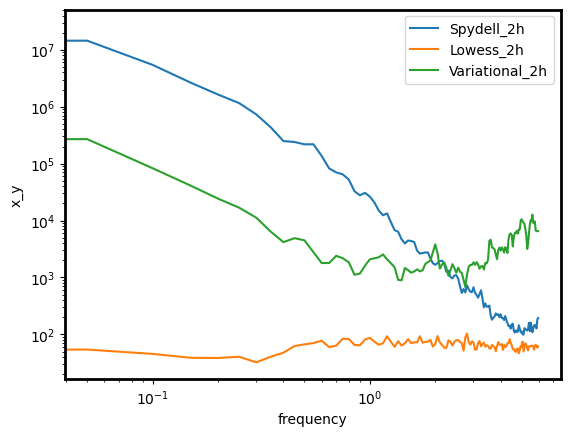

In [187]:
for l in DSE_diff:
    DSE_diff[l].x_y.mean("id").plot(label=l)
plt.xscale("log")
plt.yscale("log")
plt.legend()


## Integration per band


In [188]:
def DSE2dse(DSE):
    ds = xr.concat(DSE.values(), dim=list(DSE.keys()))
    return ds.rename({"concat_dim": "Trajectory"})


dse_diff = DSE2dse(DSE_diff)

In [189]:
dse_diff

<xarray.Dataset>
Dimensions:     (id: 10, frequency: 240, Trajectory: 3)
Coordinates:
  * id          (id) int64 0 1 2 3 4 5 6 7 8 9
  * frequency   (frequency) float64 -6.0 -5.95 -5.9 -5.85 ... 5.8 5.85 5.9 5.95
  * Trajectory  (Trajectory) object 'Spydell_2h' 'Lowess_2h' 'Variational_2h'
Data variables:
    x_y         (Trajectory, id, frequency) float64 106.7 199.9 ... 7.999e+03
    u_v         (Trajectory, id, frequency) float64 1.579e-05 ... 0.001916
    ax_ay       (Trajectory, id, frequency) float64 7.229e-12 ... 3.381e-10
    au_av       (Trajectory, id, frequency) float64 2.459e-12 ... 5.253e-10

In [190]:
def var_per_band(ds, fmin, fmax):
    return ds.where(
        (ds.frequency >= fmin) & (ds.frequency < fmax), drop=True
    ).integrate("frequency")


def ds_int_band(ds, LF=(0, 0.5), NI=(0.5, 2.5), HF=(2.5, 6)):
    if np.any(ds.frequency < 0):
        ds = sum(negpos_spectra(ds))
    BF = var_per_band(dse_diff, LF[0], LF[1]).rename(
        {v: "bf_" + v for v in [v for v in ds.keys() if v not in ds.coords]}
    )
    NI = var_per_band(dse_diff, NI[0], NI[1]).rename(
        {v: "ni_" + v for v in [v for v in ds.keys() if v not in ds.coords]}
    )
    HF = var_per_band(dse_diff, HF[0], HF[1]).rename(
        {v: "hf_" + v for v in [v for v in ds.keys() if v not in ds.coords]}
    )
    return xr.merge([BF, NI, HF])


dsbi = ds_int_band(dse_diff)
dsbi

<xarray.Dataset>
Dimensions:     (Trajectory: 3, id: 10)
Coordinates:
  * id          (id) int64 0 1 2 3 4 5 6 7 8 9
  * Trajectory  (Trajectory) object 'Spydell_2h' 'Lowess_2h' 'Variational_2h'
Data variables:
    bf_x_y      (Trajectory, id) float64 1.528e+06 1.484e+06 ... 3.433e+04
    bf_u_v      (Trajectory, id) float64 1.804e-05 1.555e-05 ... 2.284e-06
    bf_ax_ay    (Trajectory, id) float64 6.367e-13 9.556e-13 ... 5.431e-13
    bf_au_av    (Trajectory, id) float64 1.705e-12 6.442e-12 ... 3.245e-12
    ni_x_y      (Trajectory, id) float64 6.641e+04 6.305e+04 ... 3.188e+03
    ni_u_v      (Trajectory, id) float64 0.0001055 0.0001195 ... 4.58e-05
    ni_ax_ay    (Trajectory, id) float64 4.575e-12 5.321e-12 ... 3.062e-12
    ni_au_av    (Trajectory, id) float64 4.009e-12 4.705e-12 ... 3.062e-12
    hf_x_y      (Trajectory, id) float64 857.4 1.313e+03 ... 1.86e+04 1.67e+04
    hf_u_v      (Trajectory, id) float64 6.919e-05 0.0001156 ... 0.002031
    hf_ax_ay    (Trajectory, id) float64 1.184e-11 1.521e-11 ... 3.003e-10
    hf_au_av    (Trajectory, id) float64 1.161e-11 1.59e-11 ... 3.047e-10